In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import scipy.signal as ss
import h5py
import os

from analysis import plot

### Trial settings

In [2]:
setting_properties = ['duration_window', 'psd_segment_length', 'fooof_params']
settings = {
    'drifting_grating': [
        {'baseline': (.1,  .5), 'drifting_grating': (.5, 3.)}, # seconds
        {'baseline': 0.4, 'drifting_grating': 0.5}, # seconds
        {'lfp': dict(aperiodic_mode='fixed'), 'spike_rate': dict(aperiodic_mode='fixed')}
    ],
    'different_grating': [
        {'baseline': (.1,  .5), 'drifting_grating': (.5, 2.)}, # seconds
        {'baseline': 0.4, 'drifting_grating': 0.5}, # seconds
        {'lfp': dict(aperiodic_mode='fixed'), 'spike_rate': dict(aperiodic_mode='fixed')}
    ],
    'movie_5s': [
        {'movie': (0.,  3.)},
        {'movie': 0.5},
        {'lfp': {}, 'spike_rate': {}}
    ]
}
settings = pd.DataFrame.from_dict(settings, orient='index', columns=setting_properties)
settings

duration_window  \
drifting_grating   {'baseline': (0.1, 0.5), 'drifting_grating': (...   
different_grating  {'baseline': (0.1, 0.5), 'drifting_grating': (...   
movie_5s                                       {'movie': (0.0, 3.0)}   

                                           psd_segment_length  \
drifting_grating   {'baseline': 0.4, 'drifting_grating': 0.5}   
different_grating  {'baseline': 0.4, 'drifting_grating': 0.5}   
movie_5s                                       {'movie': 0.5}   

                                                        fooof_params  
drifting_grating   {'lfp': {'aperiodic_mode': 'fixed'}, 'spike_ra...  
different_grating  {'lfp': {'aperiodic_mode': 'fixed'}, 'spike_ra...  
movie_5s                               {'lfp': {}, 'spike_rate': {}}

#### Select trial

In [3]:
trial_name = 'output_movie_v_report_tau_4.0_PN2PV_10_PV2PN_10_PV2PV_0.5_BG2PN_1.5_SOM2PV_0.1'
#trial_name = 'output_changed_weight_0.8_1.4'
setting_name = 'drifting_grating'

# trial_name = 'output_different_thetas'
# setting_name = 'different_grating'

# trial_name = 'output_movie_5s'
# setting_name = 'movie_5s'

setting = settings.loc[setting_name]

#### Common parameters

In [4]:
fooof_params = dict(aperiodic_mode='knee', plt_range=100., freq_range=200., plt_log=False)
params = dict(
    channel_id = 3, # layer 5=3 layer 4=2
    scalogram_params = dict(downsample_fs=1000., log_power=True, remove_aperiodic=False, clr_freq_range=None),
    xcorr_max_lag = 200. # ms. cross-correlation mas lag
)

params['fooof_params'] = {c: {**fooof_params, **p} for c, p in setting['fooof_params'].items()}

### File paths

In [5]:
output_dir = os.path.join('..', 'V1_bio_outputs', trial_name)
data_dir = os.path.join('.', 'data')
trial_dir = os.path.join(data_dir, trial_name)

config_file = os.path.join(output_dir, 'config.json')
spikes_file = os.path.join(output_dir, 'spikes.h5')
ecp_file = os.path.join(output_dir, 'ecp.h5')

### Load data

In [6]:
v1_pop_df = pd.read_csv(os.path.join(data_dir, 'v1_population_properties.csv'),
                        index_col='pop_name', dtype={'layer': str})
layers = v1_pop_df['layer'].unique()
model_types = v1_pop_df['model_type'].unique()[::-1]

In [7]:
with h5py.File(ecp_file, 'r') as f:
    lfps = xr.DataArray(
        f['ecp']['data'][()].T,
        coords = dict(
            channel_id = f['ecp']['channel_id'][()],
            time = np.arange(*f['ecp']['time']) # ms
        ),
        attrs = dict(
            fs = 1000 / f['ecp']['time'][2] # Hz
        )
    )
n_channel = lfps.channel_id.size
display(lfps)

<xarray.DataArray (channel_id: 5, time: 25000)>
array([[ 4.35842737e-03,  6.93986153e-03,  8.46374209e-03, ...,
        -2.97390780e-03, -2.88267756e-03, -2.74890013e-03],
       [ 2.50889960e-03,  3.74243531e-03,  4.48314112e-03, ...,
        -1.17216733e-02, -1.16240967e-02, -1.15551909e-02],
       [ 9.23583039e-04,  1.55148976e-03,  2.18152849e-03, ...,
        -1.14402629e-02, -1.11040362e-02, -1.10335618e-02],
       [ 2.33040942e-03,  4.41415163e-03,  5.95708661e-03, ...,
         5.45544297e-03,  5.35273807e-03,  5.14424100e-03],
       [-1.84557913e-05,  1.40303606e-03,  2.92597898e-03, ...,
         2.41555535e-02,  2.38336372e-02,  2.34866215e-02]])
Coordinates:
  * channel_id  (channel_id) int64 0 1 2 3 4
  * time        (time) float64 0.0 0.1 0.2 0.3 ... 2.5e+03 2.5e+03 2.5e+03
Attributes:
    fs:       10000.0

In [8]:
spike_file = "spike_rate.h5"

with h5py.File(os.path.join(trial_dir, spike_file), 'r') as f:
    pop_rspk = xr.DataArray(
        np.stack([g['data'] for g in f['populations'].values()], axis=0),
        coords = dict(
            population = list(f['populations'].keys()),
            time = np.arange(*f['time'])
        ),
        attrs = dict(
            fs = 1000 / f['time'][2]
        )
    ).to_dataset(name='spike_number', promote_attrs=True)
    pop_rspk = pop_rspk.assign(
        population_number = xr.DataArray(
            [g.attrs['number'] for g in f['populations'].values()],
            coords = dict(
                population = pop_rspk.coords['population']
            )
        )
    )
    spike_rate = pop_rspk.fs / pop_rspk.population_number * pop_rspk.spike_number
    spike_rate_std = spike_rate.std(dim='time')
    idx = spike_rate_std.values > 0
    spike_rate_norm = spike_rate - spike_rate.mean(dim='time')
    spike_rate_norm[idx] /= spike_rate_std[idx]
    pop_rspk = pop_rspk.assign(
        spike_rate = spike_rate,
        spike_rate_norm = spike_rate_norm,
        spike_rate_std = spike_rate_std
    )
display(pop_rspk)

<xarray.Dataset>
Dimensions:            (population: 34, time: 1250)
Coordinates:
  * population         (population) <U11 'LIFe23' 'LIFe4' ... 'i6Pvalb' 'i6Sst'
  * time               (time) float64 0.0 2.0 4.0 ... 2.496e+03 2.498e+03
Data variables:
    spike_number       (population, time) int64 0 0 0 0 0 0 0 ... 0 0 0 2 1 0 1
    population_number  (population) int64 43368 35507 25989 ... 192 1052 1059
    spike_rate         (population, time) float64 0.0 0.0 0.0 ... 0.0 0.4721
    spike_rate_norm    (population, time) float64 -0.8794 -0.8794 ... 0.2084
    spike_rate_std     (population) float64 0.02308 0.0367 ... 1.46 0.7884
Attributes:
    fs:       500.0

### Plot traces

#### LFP

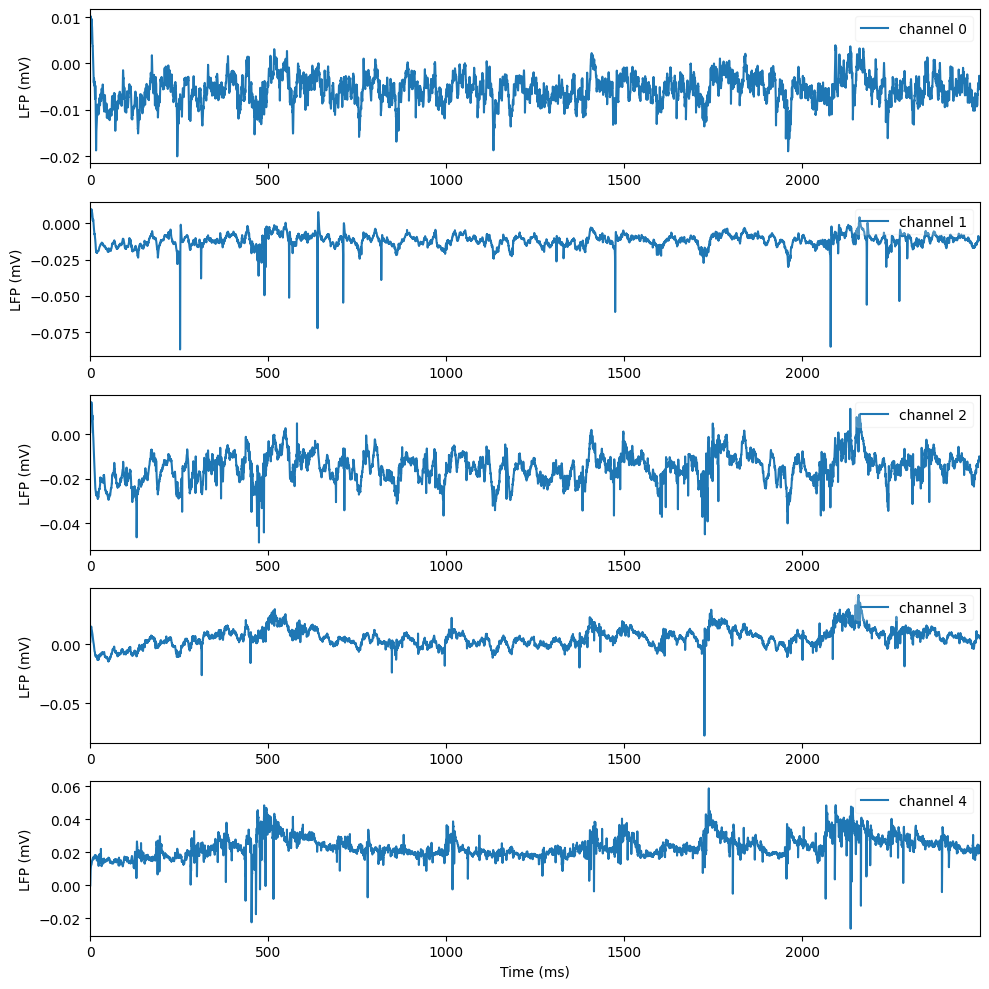

In [9]:
_, axs = plt.subplots(n_channel, 1, figsize=(10, 2 * n_channel))
for i, ax in enumerate(axs):
    ax.plot(lfps.time, lfps.isel(channel_id=i), label=f'channel {lfps.channel_id.values[i]:d}')
    ax.set_xlim(lfps.time[[0, -1]])
    ax.legend(loc='upper right', framealpha=0.2)
    ax.set_ylabel('LFP (mV)')
axs[-1].set_xlabel('Time (ms)')
plt.tight_layout()
plt.show()


#### Spike time histogram

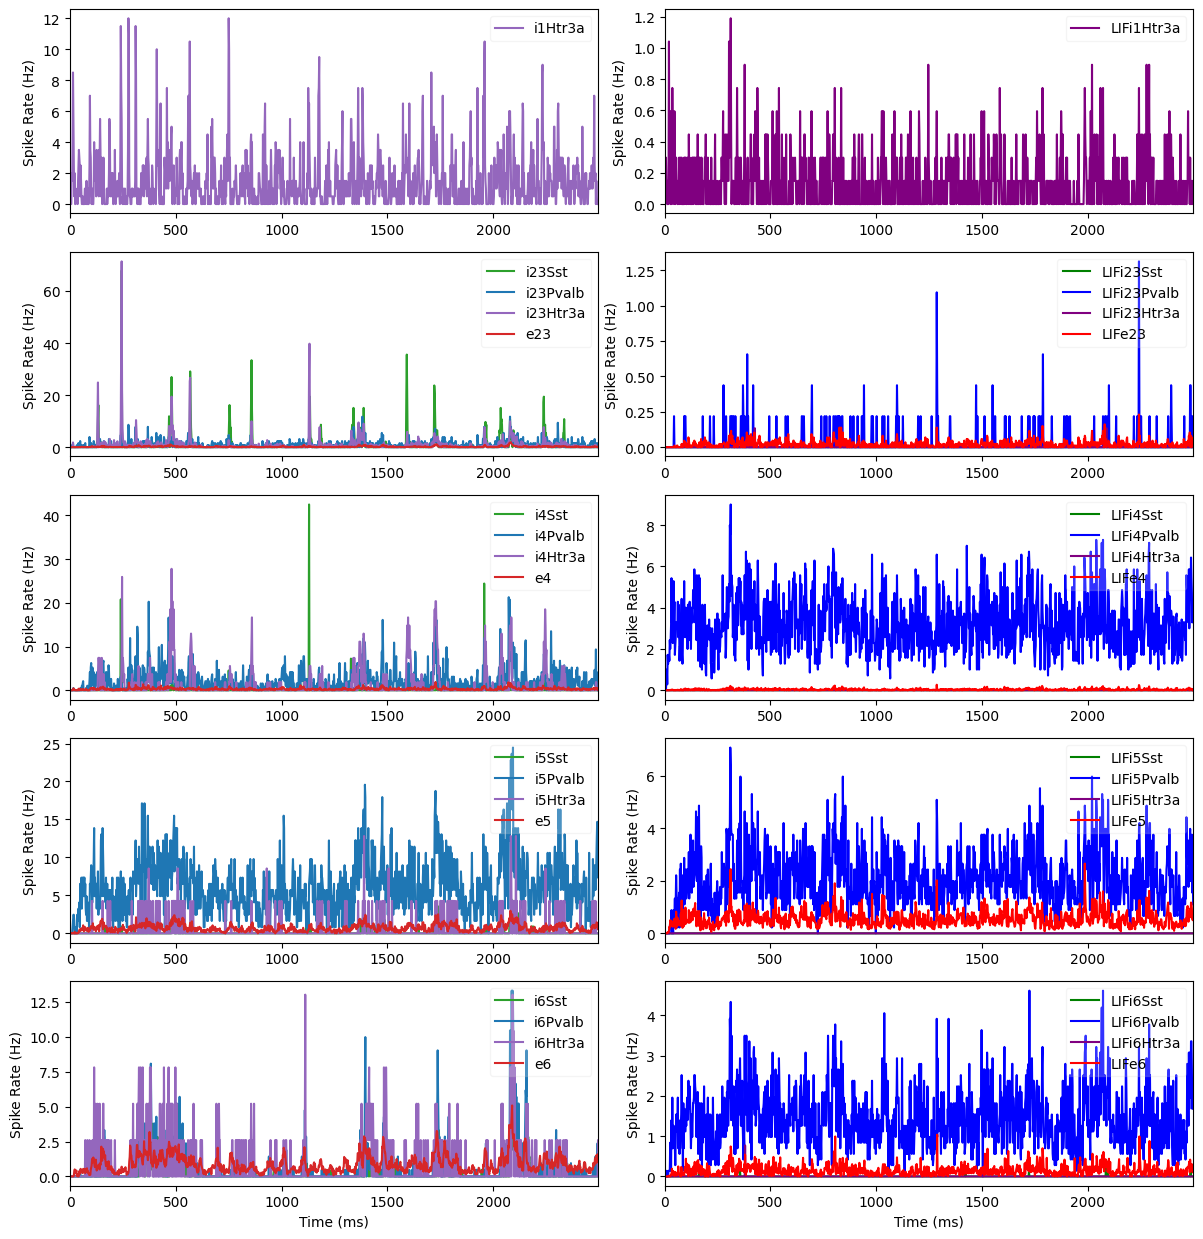

In [10]:
_, axs = plt.subplots(len(layers), 2, figsize=(12, 2.5 * len(layers)))
spike_rate = pop_rspk.spike_rate
for i, L in enumerate(layers):
    for j, M in enumerate(model_types):
        ax = axs[i, j]
        pops = v1_pop_df.index[(v1_pop_df['layer'] == L) & (v1_pop_df['model_type'] == M)]
        for p in pops[::-1]:
            ax.plot(spike_rate.time, spike_rate.sel(population=p), color=v1_pop_df.loc[p, 'color'], label=p)
        ax.set_xlim(spike_rate.time[[0, -1]])
        ax.legend(loc='upper right', framealpha=0.2)
        ax.set_ylabel('Spike Rate (Hz)')
for ax in axs[-1, :]:
    ax.set_xlabel('Time (ms)')
plt.tight_layout()
plt.show()

### PSD of LFP

baseline
Channel:  3
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 5 - 200 Hz                        
                                 Frequency Resolution is 2.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -4.7972, 1.8767                                          
                                                                                                  
                                       8 peaks were found:                              

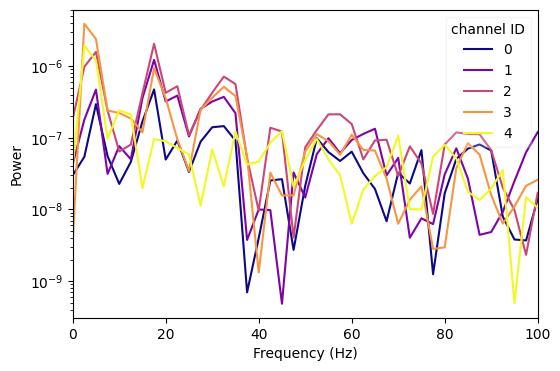

<Figure size 640x480 with 0 Axes>

drifting_grating
Channel:  3
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 4 - 200 Hz                        
                                 Frequency Resolution is 2.00 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -4.5275, 1.7442                                          
                                                                                                  
                                       9 peaks were found:                      

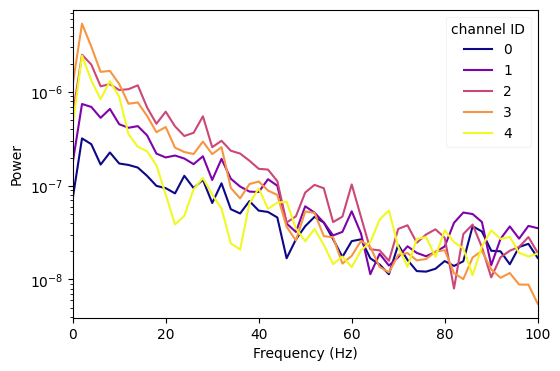

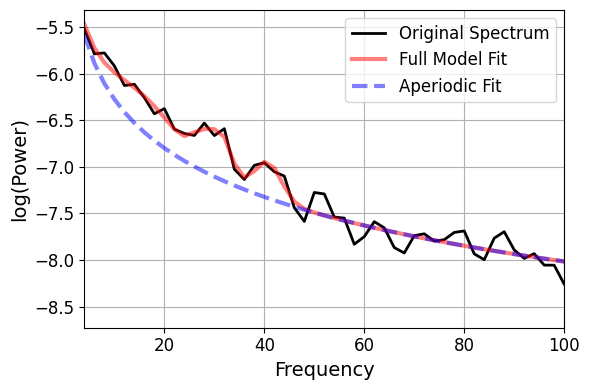

<Figure size 640x480 with 0 Axes>

In [11]:
durations = list(setting.duration_window.keys())
lfp_fs = lfps.fs
psd_lfp = {}
for dur in durations:
    print(dur)
    tseg = setting.psd_segment_length[dur]
    time_window = 1000 * np.array(setting.duration_window[dur]) # ms
    nperseg = int(tseg * lfp_fs)
    f, pxx = ss.welch(lfps.sel(time=slice(*time_window)).values, fs=lfp_fs, nperseg=nperseg)
    psd_lfp[dur] = xr.DataArray(
        pxx,
        coords = {'channel': lfps.channel_id.values, 'frequency': f},
        attrs = {'nperseg': nperseg}
    )
    _ = plot.plot_channel_psd(psd_lfp[dur], channel_id=params['channel_id'],
                              **params['fooof_params']['lfp'], figsize=(6, 4))
    plt.show()

#### Scalogram

In [12]:
lfp_sxx = plot.cwt_spectrogram_xarray(
    lfps, lfp_fs,
    axis = lfps.dims.index('time'),
    downsample_fs = params['scalogram_params']['downsample_fs'],
    channel_coords = {'channel_id': lfps.channel_id}
)

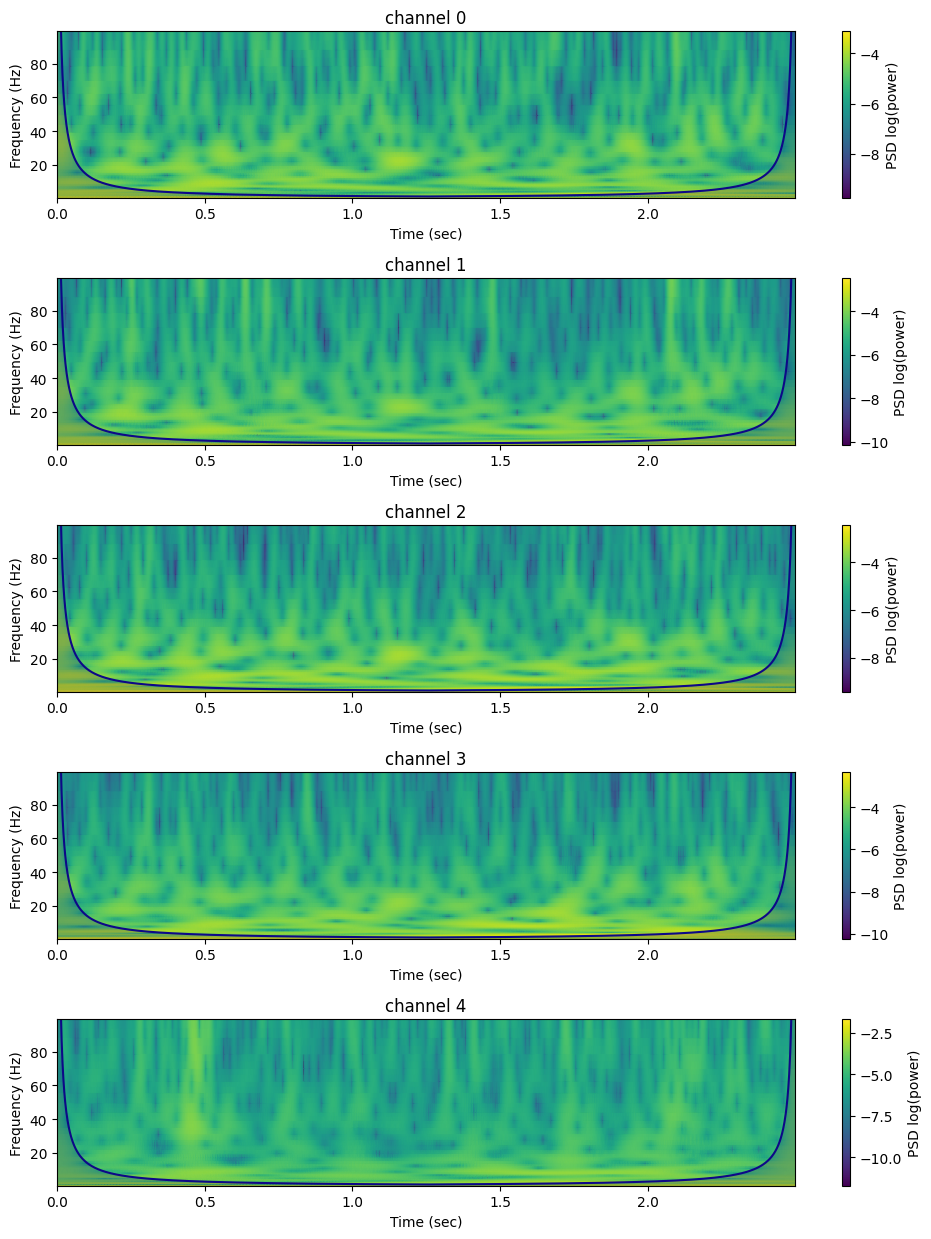

In [13]:
scalogram_params = params['scalogram_params']
remove_aperiodic = params['fooof_params']['lfp'] if scalogram_params['remove_aperiodic'] else None
_, axs = plt.subplots(n_channel, 1, figsize=(10, 2.5 * n_channel))
for i, ax in enumerate(axs):
    sxx = lfp_sxx.isel(channel_id=i)
    channel_id = sxx.channel_id.values
    if remove_aperiodic is None:
        fooof_results = None
    else:
        sxx_tot = sxx.PSD.mean(dim='time')
        fooof_results, _ = plot.fit_fooof(sxx_tot.frequency.values, sxx_tot.values, **remove_aperiodic)
    _ = plot.plot_spectrogram(sxx, remove_aperiodic=fooof_results,
                                log_power=scalogram_params['log_power'],
                                plt_range=params['fooof_params']['lfp']['plt_range'],
                                clr_freq_range=scalogram_params['clr_freq_range'], ax=ax)
    ax.set_title(f'channel {channel_id:d}')
plt.tight_layout()
plt.show()

### PSD of spike time histogram

In [14]:
durations = list(setting.duration_window.keys())
rspk_fs = pop_rspk.fs
# PSD
psd_rspk = {}
for dur in durations:
    tseg = setting.psd_segment_length[dur]
    time_window = 1000 * np.array(setting.duration_window[dur]) # ms
    nperseg = int(tseg * rspk_fs)
    f, pxx = ss.welch(pop_rspk.spike_rate_norm.sel(time=slice(*time_window)).values, fs=rspk_fs, nperseg=nperseg)
    psd_rspk[dur] = xr.DataArray(
        pxx,
        coords={'population': pop_rspk.population.values, 'frequency': f},
        attrs = {'nperseg': nperseg}
    )

# CWT
rspk_sxx = plot.cwt_spectrogram_xarray(
    pop_rspk.spike_rate_norm, rspk_fs,
    axis = pop_rspk.spike_rate_norm.dims.index('time'),
    downsample_fs = params['scalogram_params']['downsample_fs'],
    channel_coords = {'population': pop_rspk.population}
)

baseline


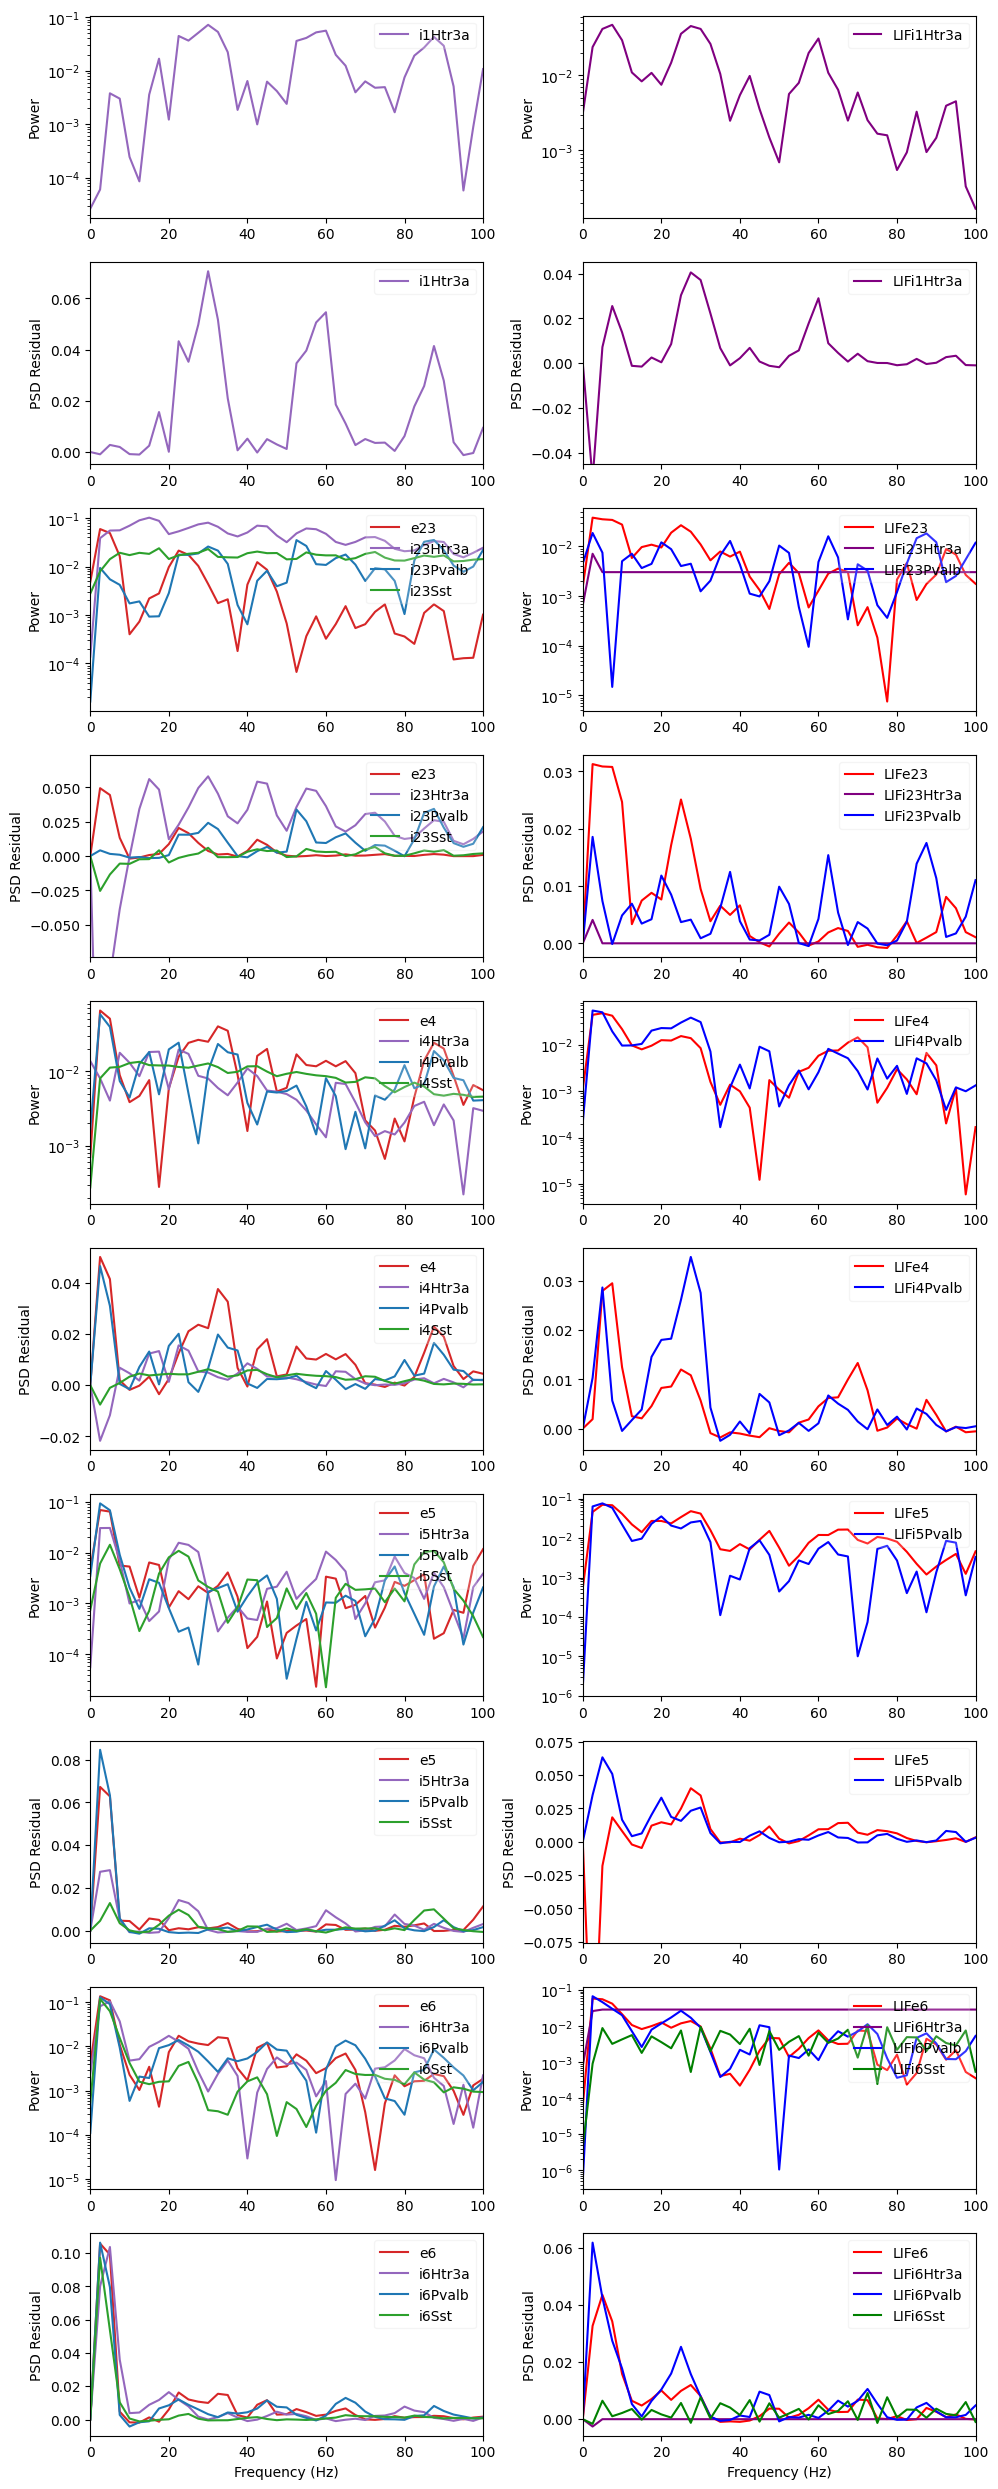

drifting_grating


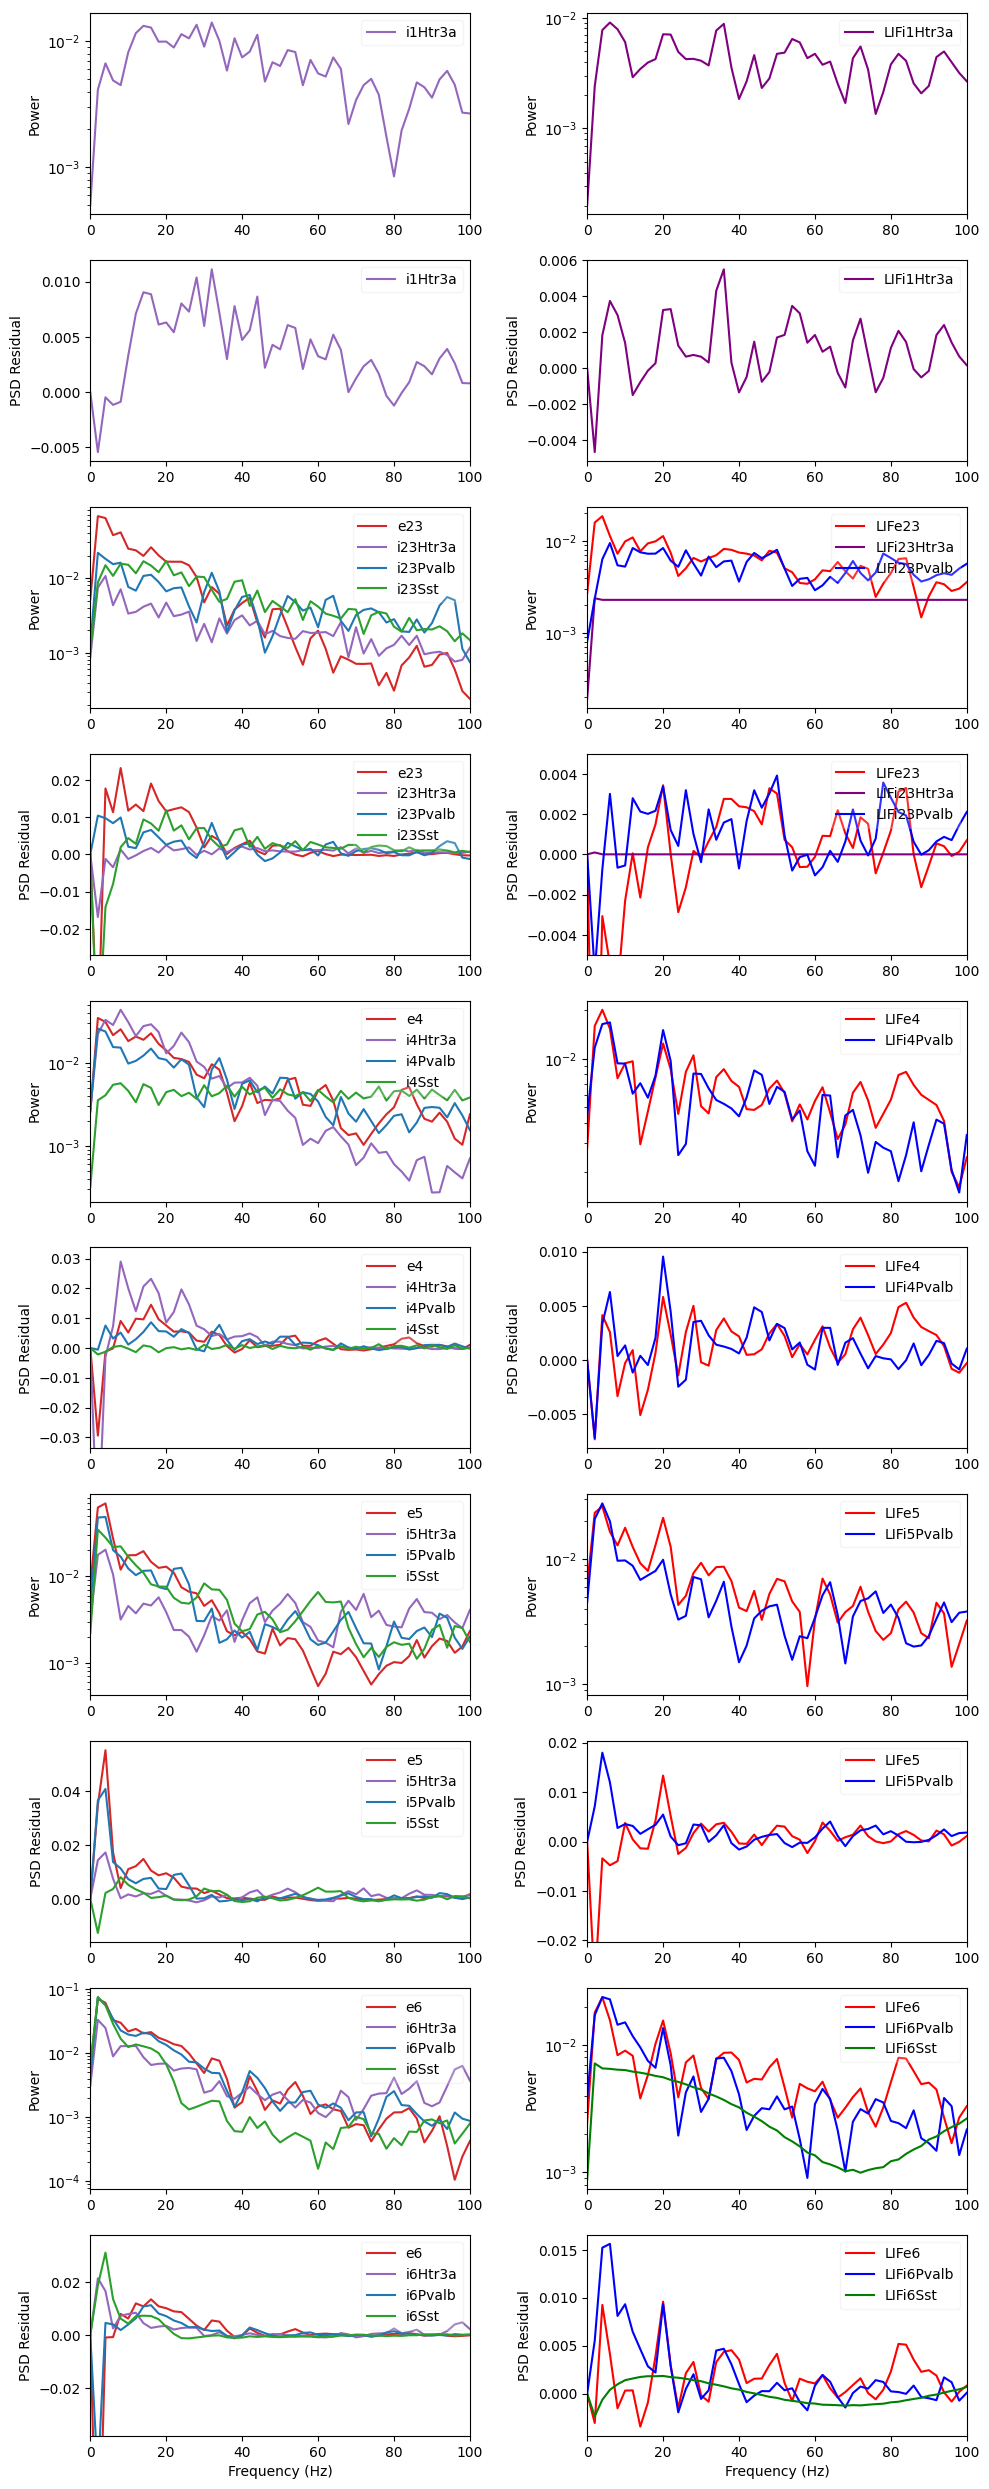

In [15]:
for dur in durations:
    print(dur)
    f = psd_rspk[dur].frequency.values
    plt_range = params['fooof_params']['spike_rate']['plt_range']
    plt_range = np.array(f[-1]) if plt_range is None else np.array(plt_range)
    if plt_range.size == 1:
        plt_range = [0., plt_range.item()]
    f_idx = (f >= plt_range[0]) & (f <= plt_range[1])

    _, axs = plt.subplots(2 * len(layers), 2, figsize=(10, 2.5 * 2 * len(layers)))
    for i, L in enumerate(layers):
        for j, M in enumerate(model_types):
            ax2 = axs[2 * i:2 * i + 2, j]
            pops = v1_pop_df.index[(v1_pop_df['layer'] == L) & (v1_pop_df['model_type'] == M)]
            for p in pops:
                psd = psd_rspk[dur].sel(population=p).values
                idx = psd > 0
                if not np.any(idx):
                    continue
                # calculate residual
                fooof_results, _ = plot.fit_fooof(f[idx], psd[idx], report=False, plot=False,
                                                  **params['fooof_params']['spike_rate'])
                res_psd, _ = plot.psd_residual(f, psd, fooof_results, plot=False)
                idx &= f_idx
                ax = ax2[0]
                ax.plot(f[idx], psd[idx], color=v1_pop_df.loc[p, 'color'], label=p)
                ax.set_yscale('log')
                ax.set_ylabel('Power')
                ax = ax2[1]
                ax.plot(f[idx], res_psd[idx], color=v1_pop_df.loc[p, 'color'], label=p)
                ax.set_ylabel('PSD Residual')
            yl = ax.get_ylim()
            ax.set_ylim(bottom=max(yl[0], -yl[1]))
            for ax in ax2:
                ax.set_xlim(plt_range)
                ax.legend(loc='upper right', framealpha=0.2)
    for j, M in enumerate(model_types):
        axs[-1, j].set_xlabel('Frequency (Hz)')
    plt.tight_layout()
    plt.show()

#### Scalogram

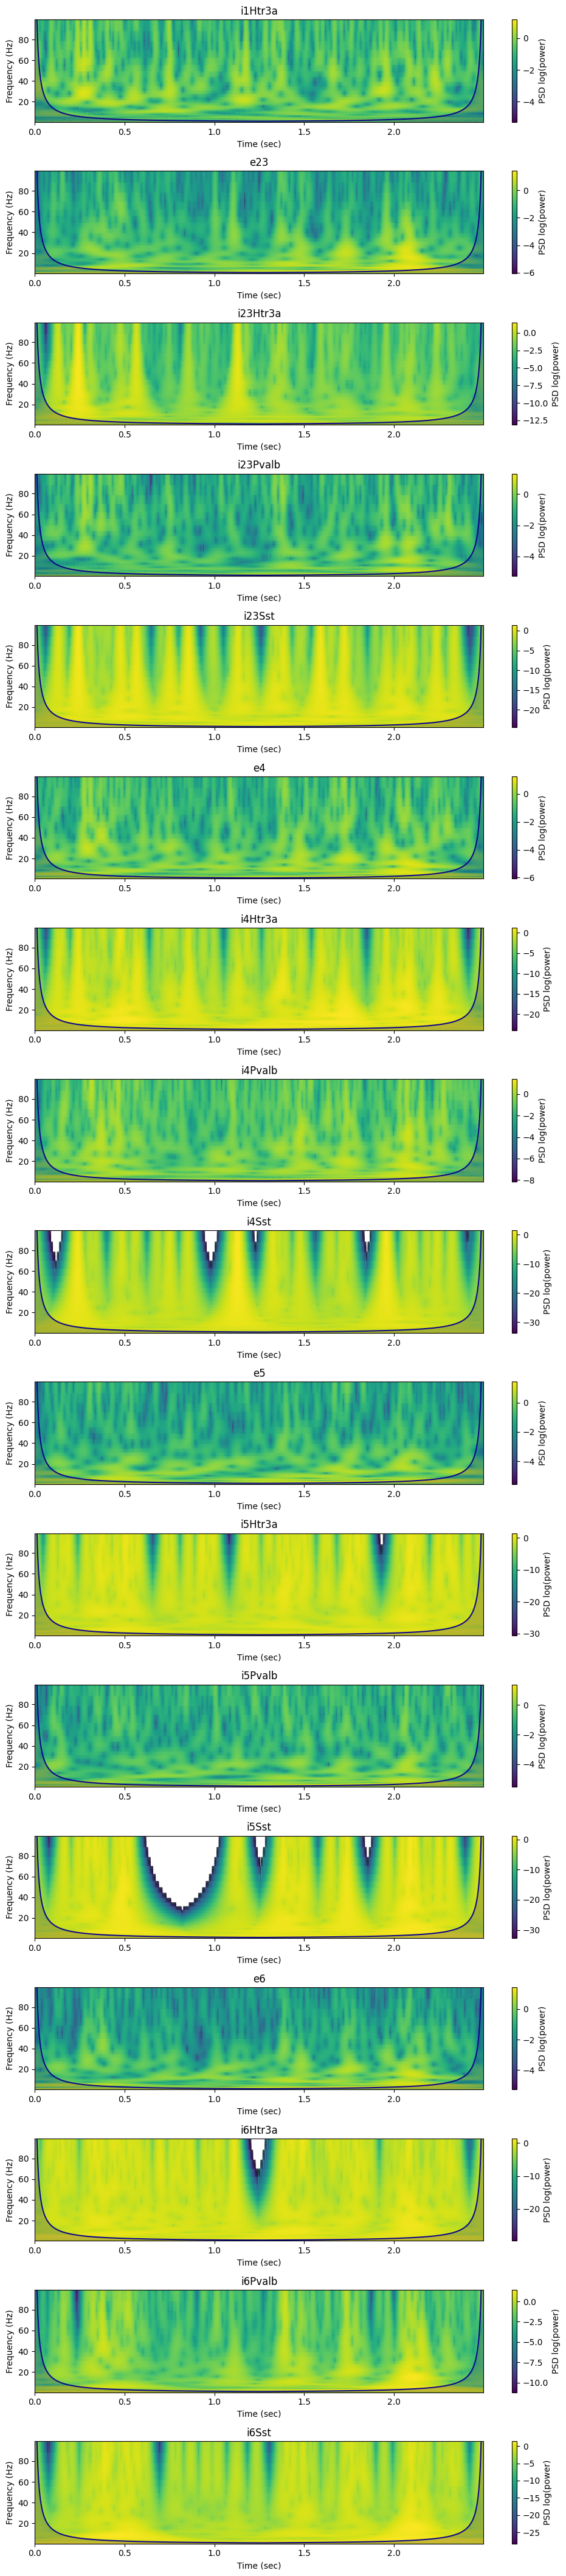

In [16]:
scalogram_params = params['scalogram_params']
remove_aperiodic = params['fooof_params']['spike_rate'] if scalogram_params['remove_aperiodic'] else None
pops = v1_pop_df.index[v1_pop_df['model_type'] == 'biophysical']

_, axs = plt.subplots(pops.size, 1, figsize=(10, 2.5 * pops.size))
for p, ax in zip(pops, axs):
    sxx = rspk_sxx.sel(population=p)
    if remove_aperiodic is None:
        fooof_results = None
    else:
        sxx_tot = sxx.PSD.mean(dim='time')
        fooof_results, _ = plot.fit_fooof(sxx_tot.frequency.values, sxx_tot.values, **remove_aperiodic)
    _ = plot.plot_spectrogram(sxx, remove_aperiodic=fooof_results,
                                log_power=scalogram_params['log_power'],
                                plt_range=params['fooof_params']['spike_rate']['plt_range'],
                                clr_freq_range=scalogram_params['clr_freq_range'], ax=ax)
    ax.set_title(p)
plt.tight_layout()
plt.show()

#### Cross-correlation and coherence

In [17]:
layer_pairs = (('23', '23'), ('4', '4'), ('5', '5'), ('6', '6'))
cell_type_pairs = (('e', 'Pvalb'), ('e', 'Sst'), ('e', 'Htr3a'))
v1_pop_bio = v1_pop_df[v1_pop_df['model_type'] == 'biophysical']
xcorr_pairs = np.reshape(
    [v1_pop_bio.index[(v1_pop_bio['layer'] == L[i]) & (v1_pop_bio['cell_type'] == C[i])][0]
     for L in layer_pairs for C in cell_type_pairs for i in range(2)],
    (len(layer_pairs), len(cell_type_pairs), 2)
)

baseline


/home/gjgpb9/miniconda3/envs/bmtk/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gjgpb9/miniconda3/envs/bmtk/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


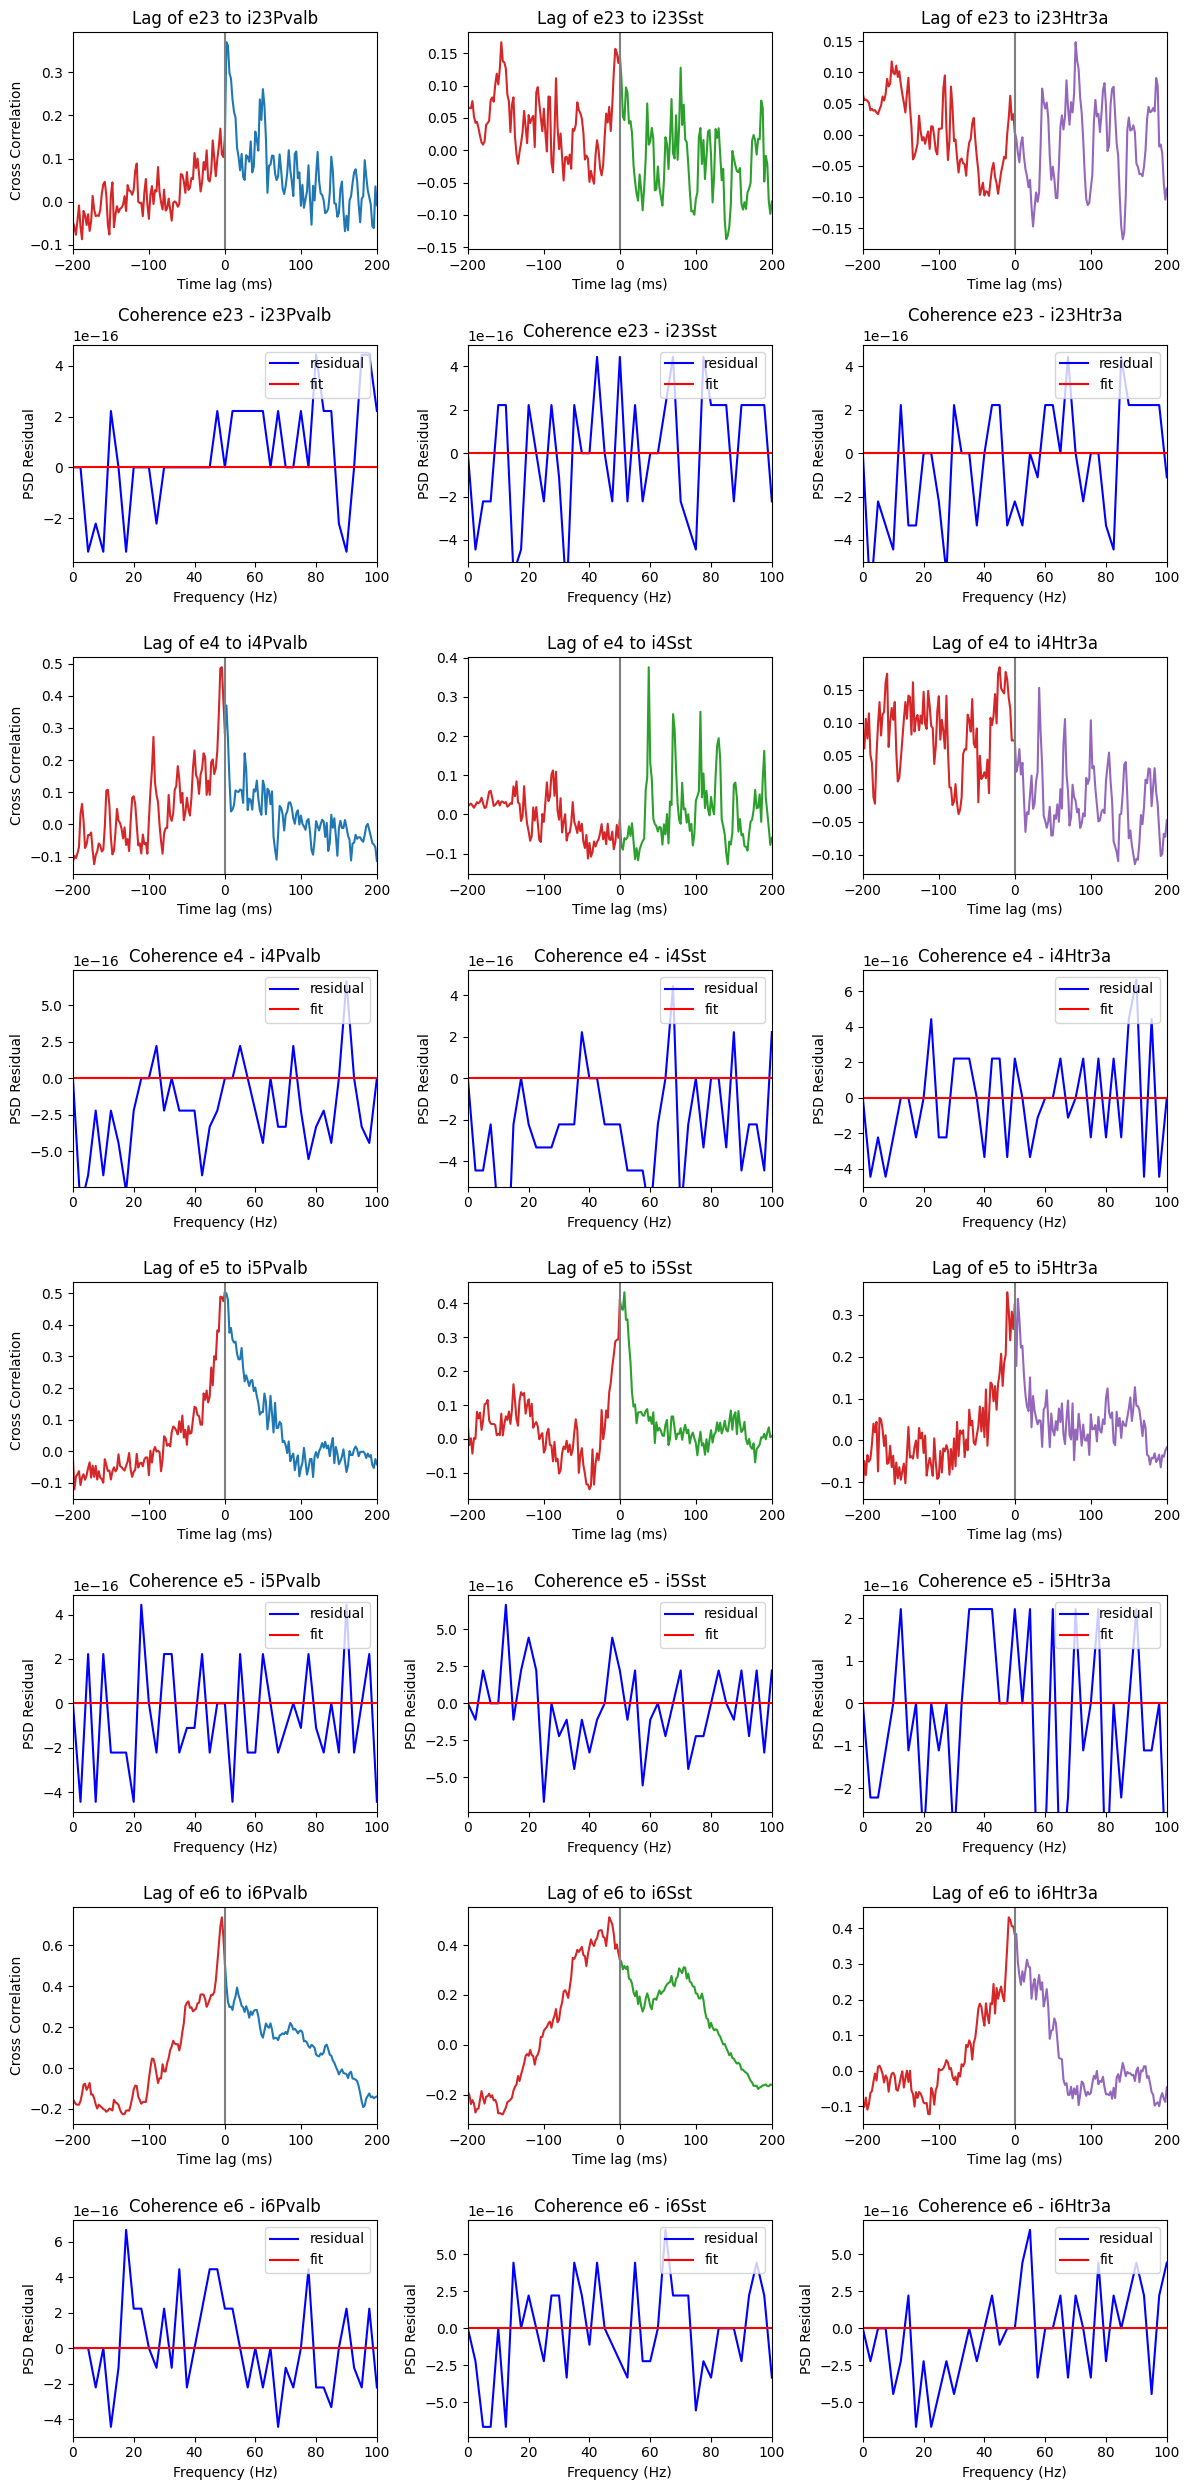

drifting_grating


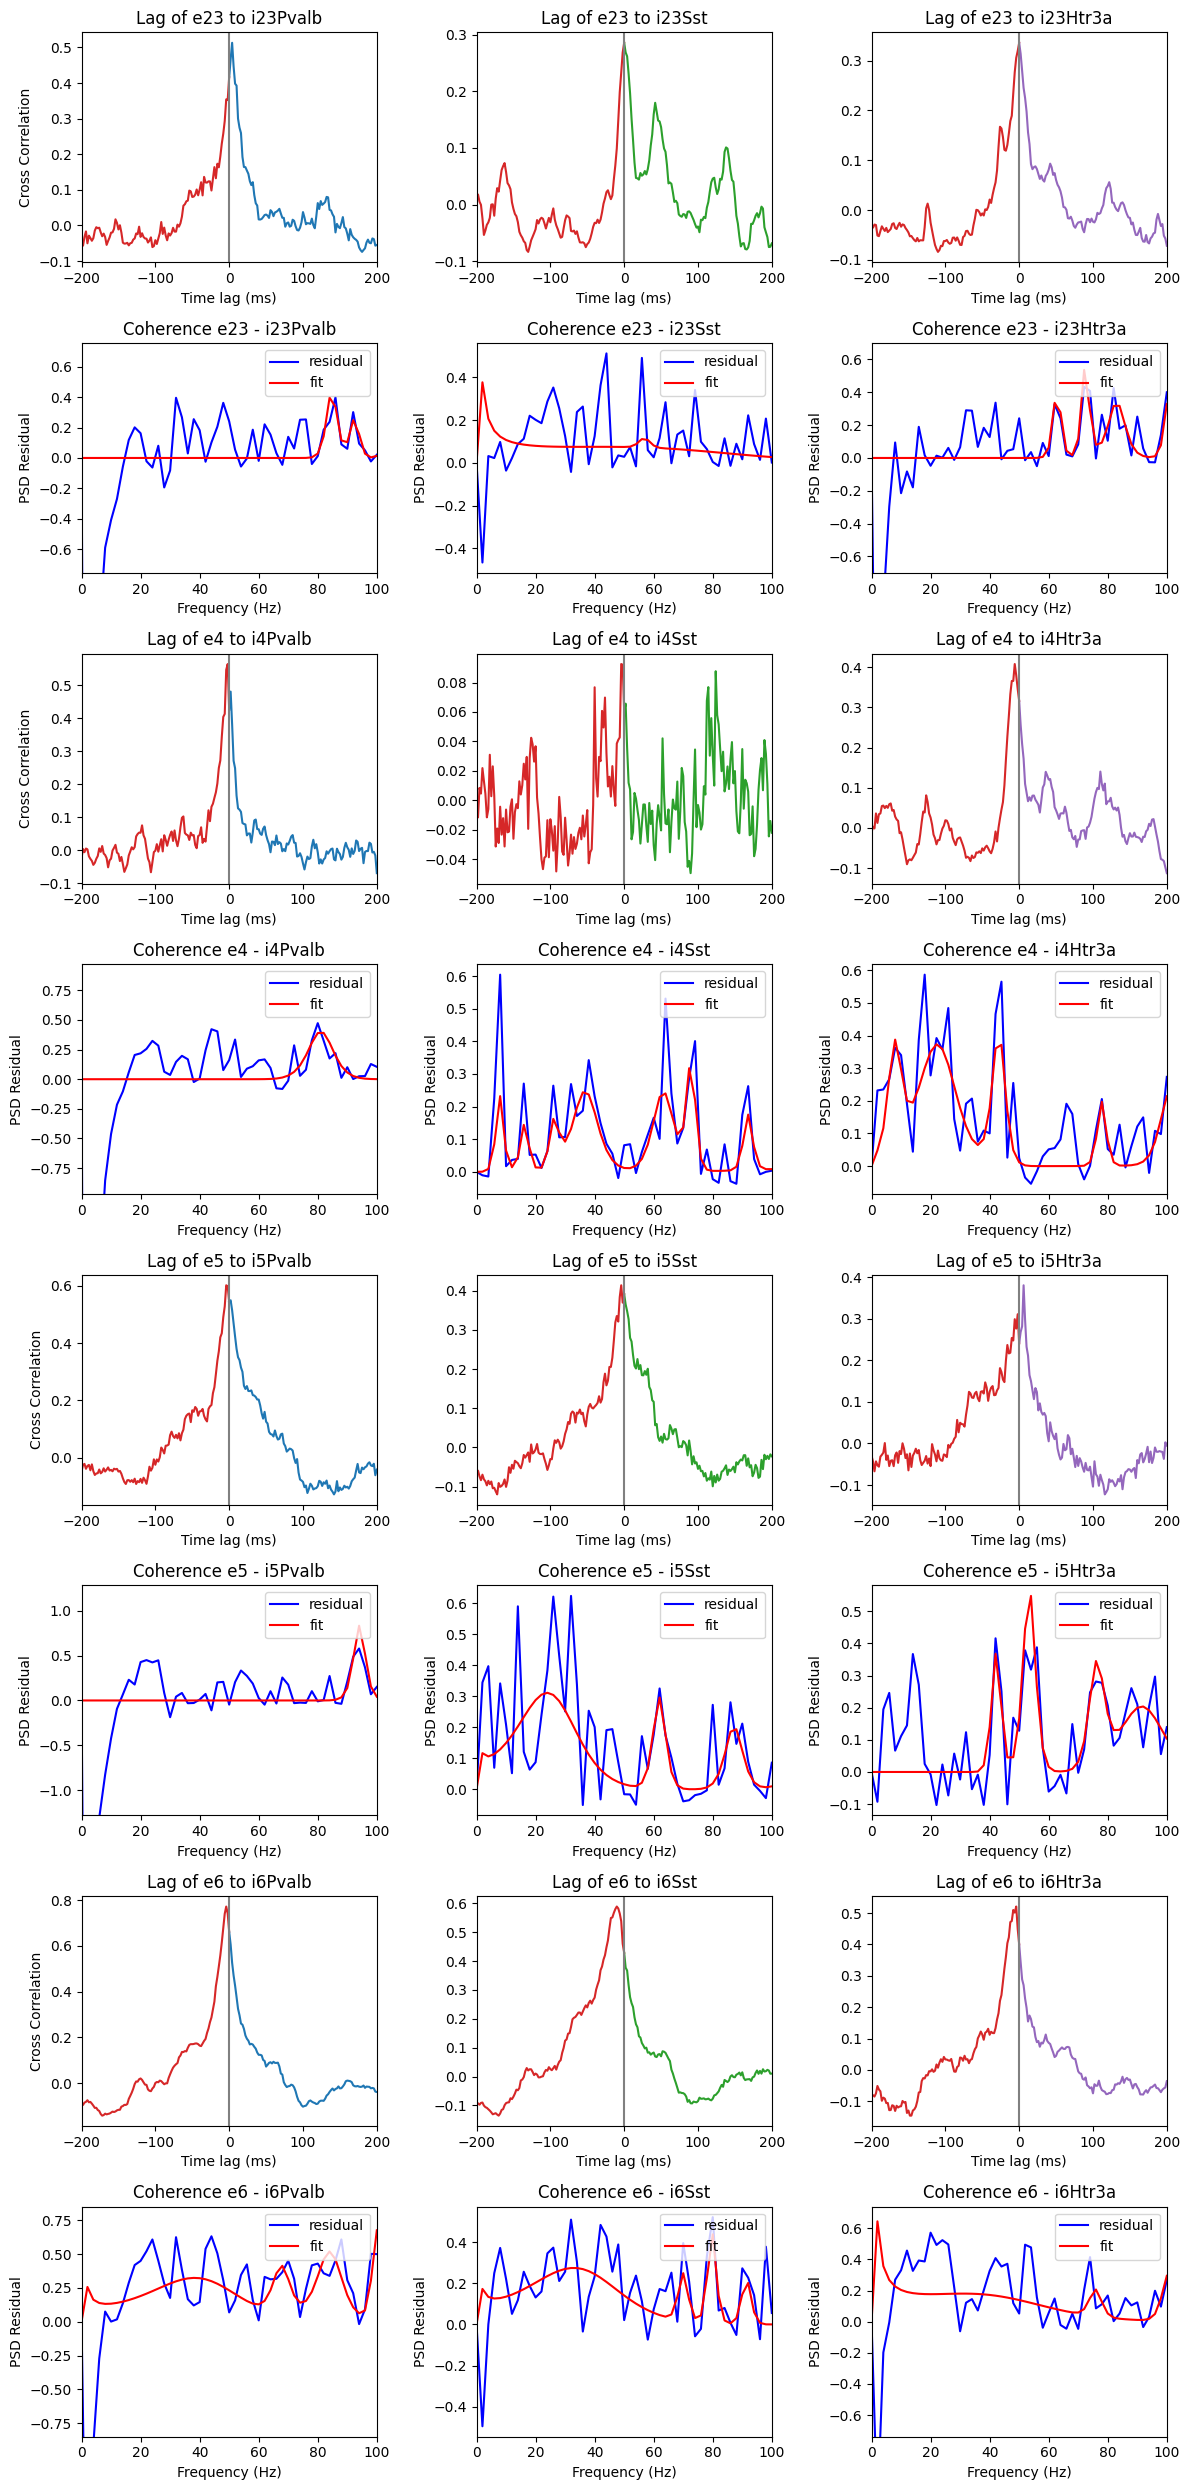

In [18]:
max_lag = params['xcorr_max_lag']
dt = 1000 / rspk_fs
for dur in durations:
    print(dur)
    time_window = 1000 * np.array(setting.duration_window[dur]) # ms
    spike_rate = pop_rspk.spike_rate_norm.sel(time=slice(*time_window))
    idx0 = min(int(max_lag / dt), spike_rate.time.size - 1)
    f = psd_rspk[dur].frequency.values
    plt_range = params['fooof_params']['spike_rate']['plt_range']

    _, axs = plt.subplots(2 * len(layer_pairs), len(cell_type_pairs),
                          figsize=(4 * len(cell_type_pairs), 2 * 2.5 * len(layers)), squeeze=False)
    for i in range(len(layer_pairs)):
        for j in range(len(cell_type_pairs)):
            ax2 = axs[2 * i:2 * i + 2, j]
            # cross-correlation
            pair = xcorr_pairs[i, j]
            colors = v1_pop_df.loc[pair, 'color']
            rspk_pair = spike_rate.sel(population=pair).values
            xcorr, xcorr_lags = plot.xcorr_coeff(*rspk_pair, dt=dt, max_lag=max_lag, plot=False)
            ax = ax2[0]
            ax.plot(xcorr_lags[:idx0 + 1], xcorr[:idx0 + 1], color=colors[0])
            ax.plot(xcorr_lags[idx0:], xcorr[idx0:], color=colors[1])
            ax.axvline(0., color='gray')
            ax.set_xlim(xcorr_lags[[0, -1]])
            ax.set_xlabel('Time lag (ms)')
            ax.set_title(f'Lag of {pair[0]:s} to {pair[1]:s}')
            # coherence
            f, cxy = ss.coherence(*rspk_pair, fs=rspk_fs, nperseg=psd_rspk[dur].nperseg)
            idx = cxy > 0
            if not np.any(idx):
                continue
            # calculate residual
            fooof_results, _ = plot.fit_fooof(f[idx], cxy[idx], report=False, plot=False,
                                              **params['fooof_params']['spike_rate'])
            ax = ax2[1]
            _ = plot.psd_residual(f, cxy, fooof_results, plot=True, plt_range=plt_range, ax=ax)
            yl = ax.get_ylim()
            ax.set_ylim(bottom=max(yl[0], -yl[1]))
            ax.set_title(f'Coherence {pair[0]:s} - {pair[1]:s}')
        axs[2 * i, 0].set_ylabel('Cross Correlation')
    plt.tight_layout()
    plt.show()